In [38]:
# Path: src\analysis.ipynb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from values import Values
plt.rcParams['font.size'] = 17

In [39]:
directory = '../data/c3_data'
c3_data = {}

for filename in os.listdir(directory):
    if os.path.isfile(os.path.join(directory, filename)):
        c3_data[filename] = pd.DataFrame(pd.read_csv(os.path.join(directory, filename))).drop(0).reset_index(drop=True).astype(np.float64)

In [40]:
linear = lambda x,m,c: m*x+c
gaussian = lambda x, a, b, c, d: a * np.exp(-((x-b)/c)**2) + d

In [41]:
def plot_data(fig, ax, data: dict, plot_label: str, xlabel: str, ylabel: str, xlims: tuple = None, ylims: tuple = None, marker: str = "x", linestyle: str = "None", color: str = "black", markersize: int = 10):
    # Data
    x = np.array(list(data.keys()))
    y = np.array(list(data.values()))

    # Plotting
    ax.plot(
        x,
        y,
        marker=marker,
        linestyle=linestyle,
        color=color,
        label=plot_label,
        markersize=markersize
    )


    # Graph Customisation
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(xlims if xlims != None else None)
    ax.set_ylim(ylims if ylims != None else None)
    ax.legend()

    fig.tight_layout()


In [42]:
c3_voltages = np.linspace(3, 10, 15)    # Field voltages used in experiment
d_3 = 375e-6                            # distance between emitter and contact 3 (C3)
BARLENGTH = 950e-6                      # length of the bar
hole_effective_mass = 0.41*9.11e-31     # effective mass of holes
k_b = 1.38e-23                          # Boltzmann constant
charge = 1.6e-19                        # charge of an electron
temperature = 300                       # temperature of the experiment

peak_times = np.array([])               # Times at which pulse peaks occur
peak_voltages = np.array([])            # Amplitudes of pulse peaks
pulse_durations = np.array([])          # Pulse durations


## Viewing the Data

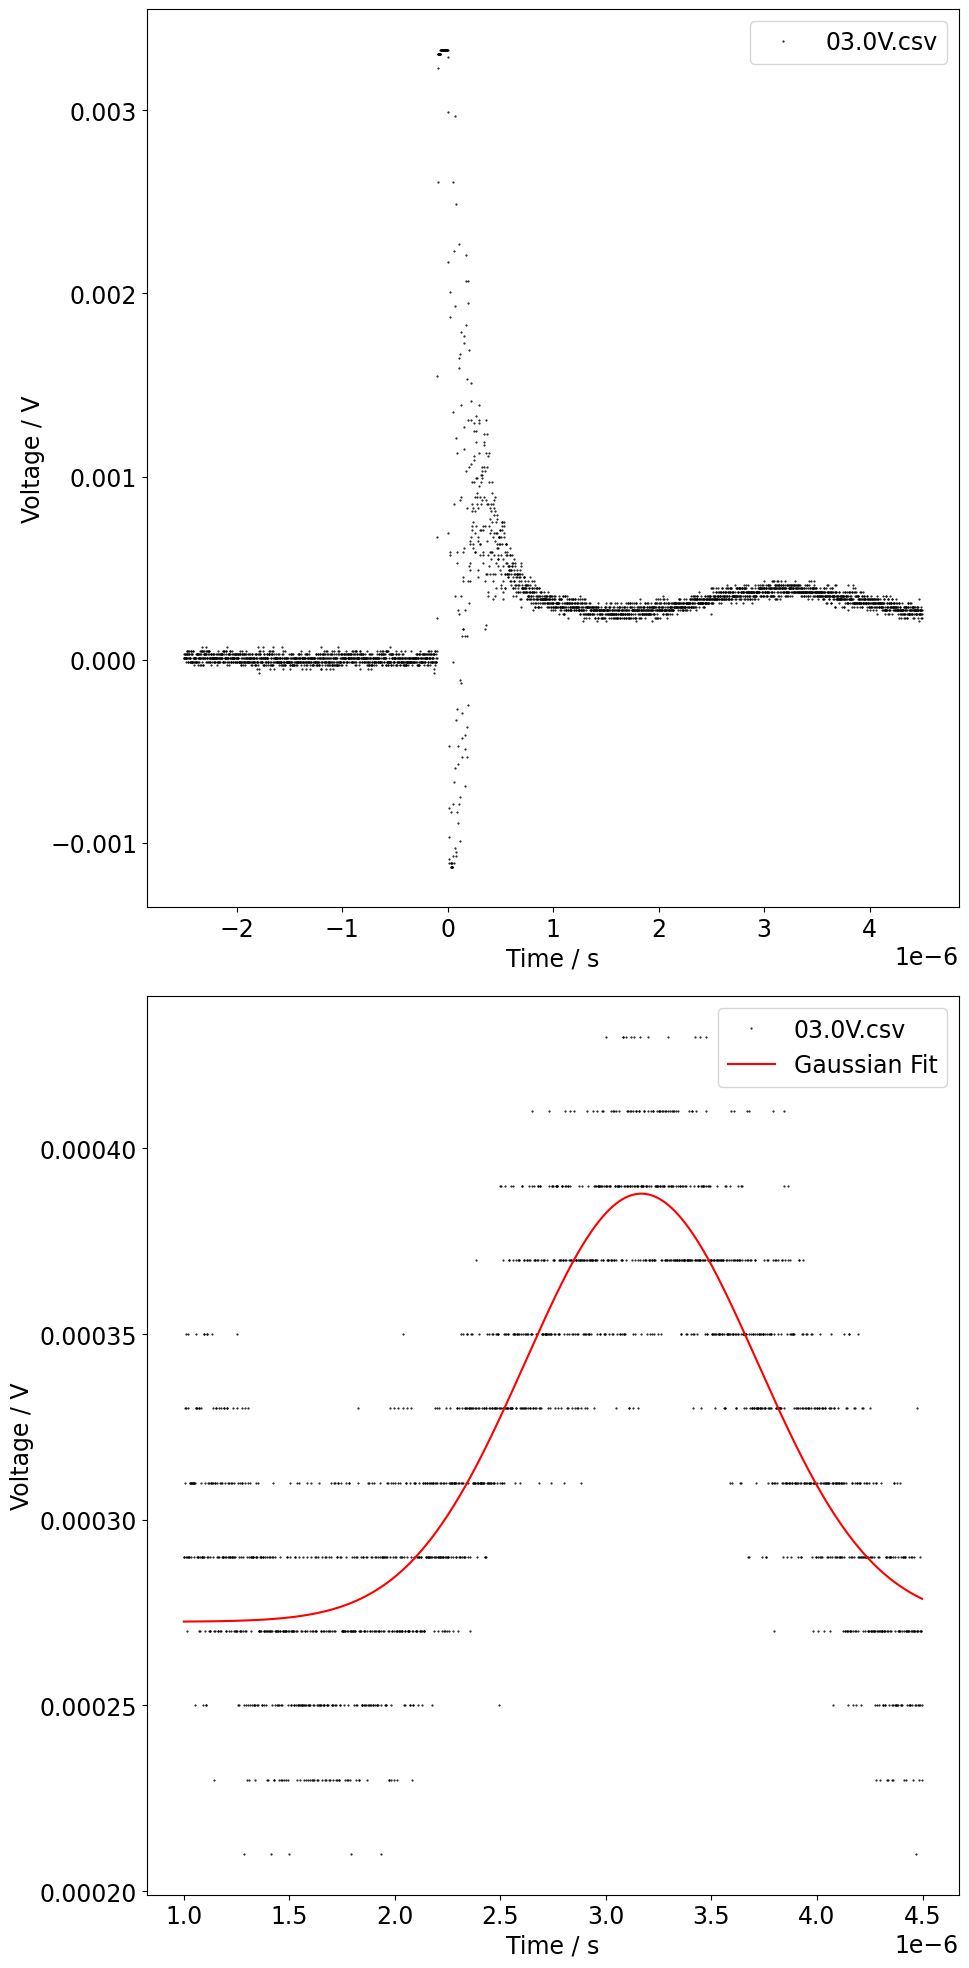

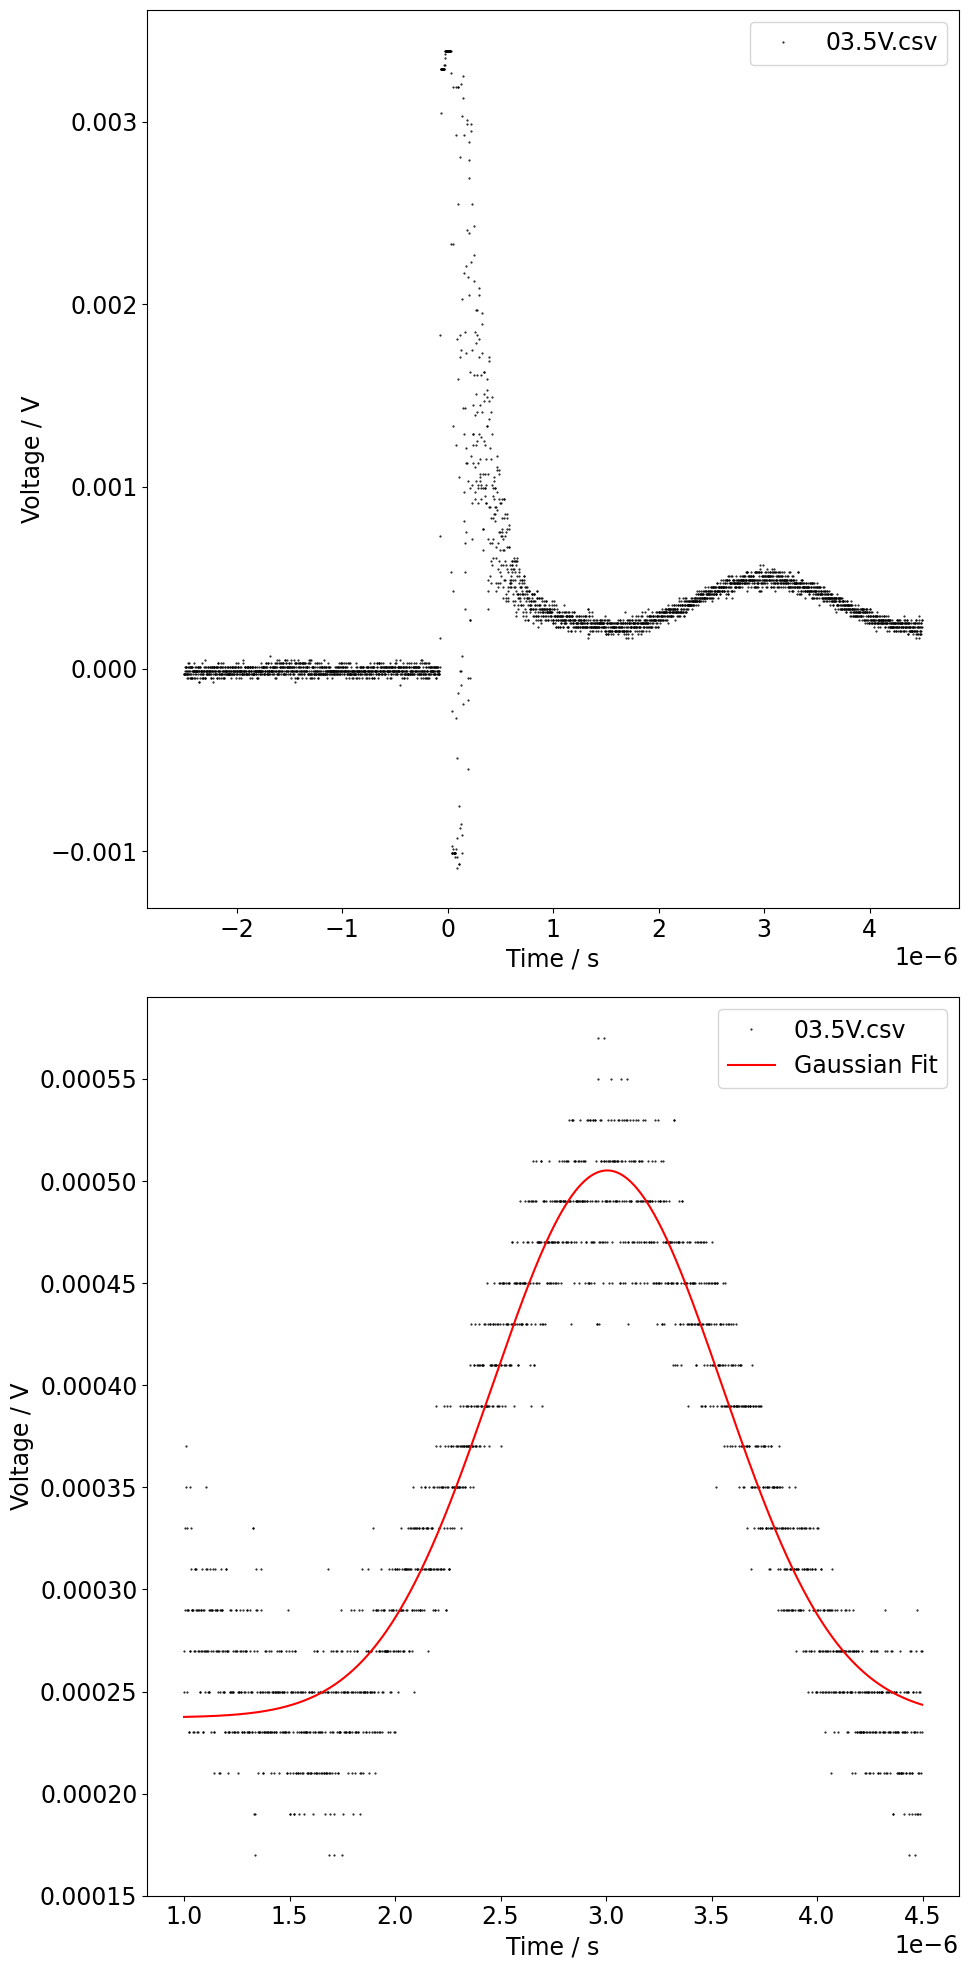

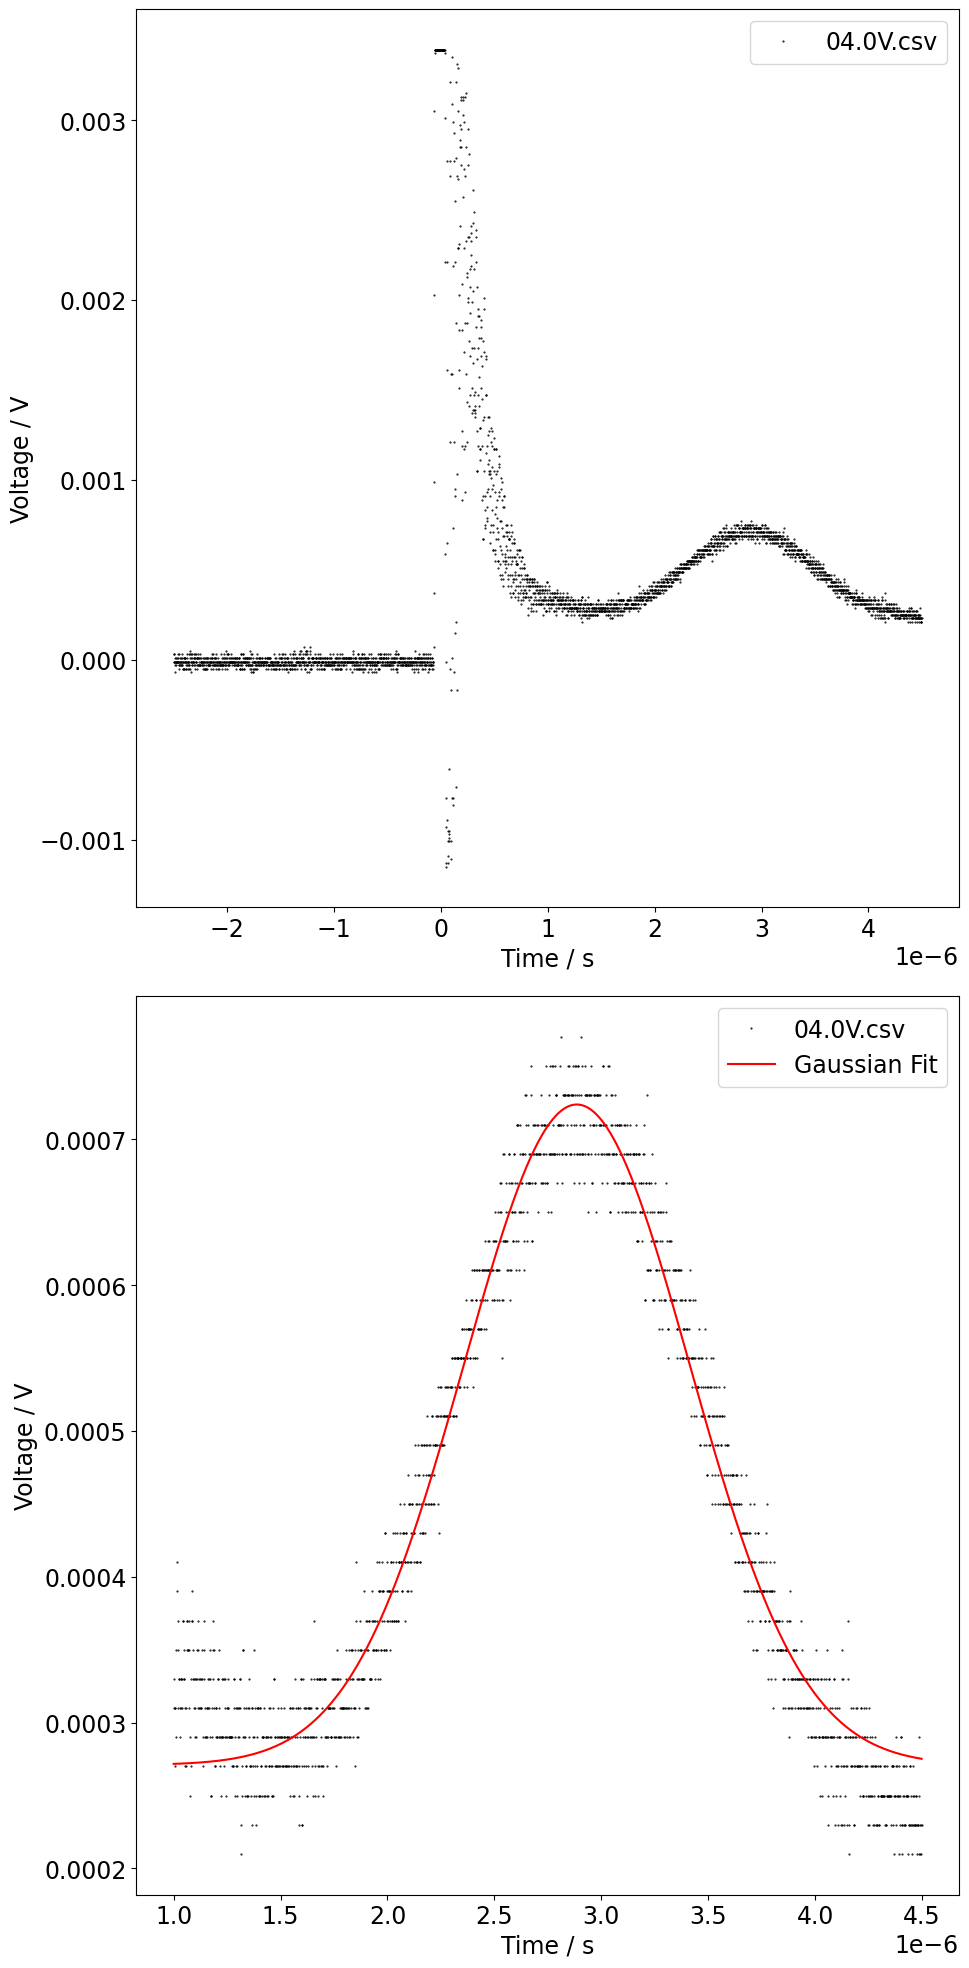

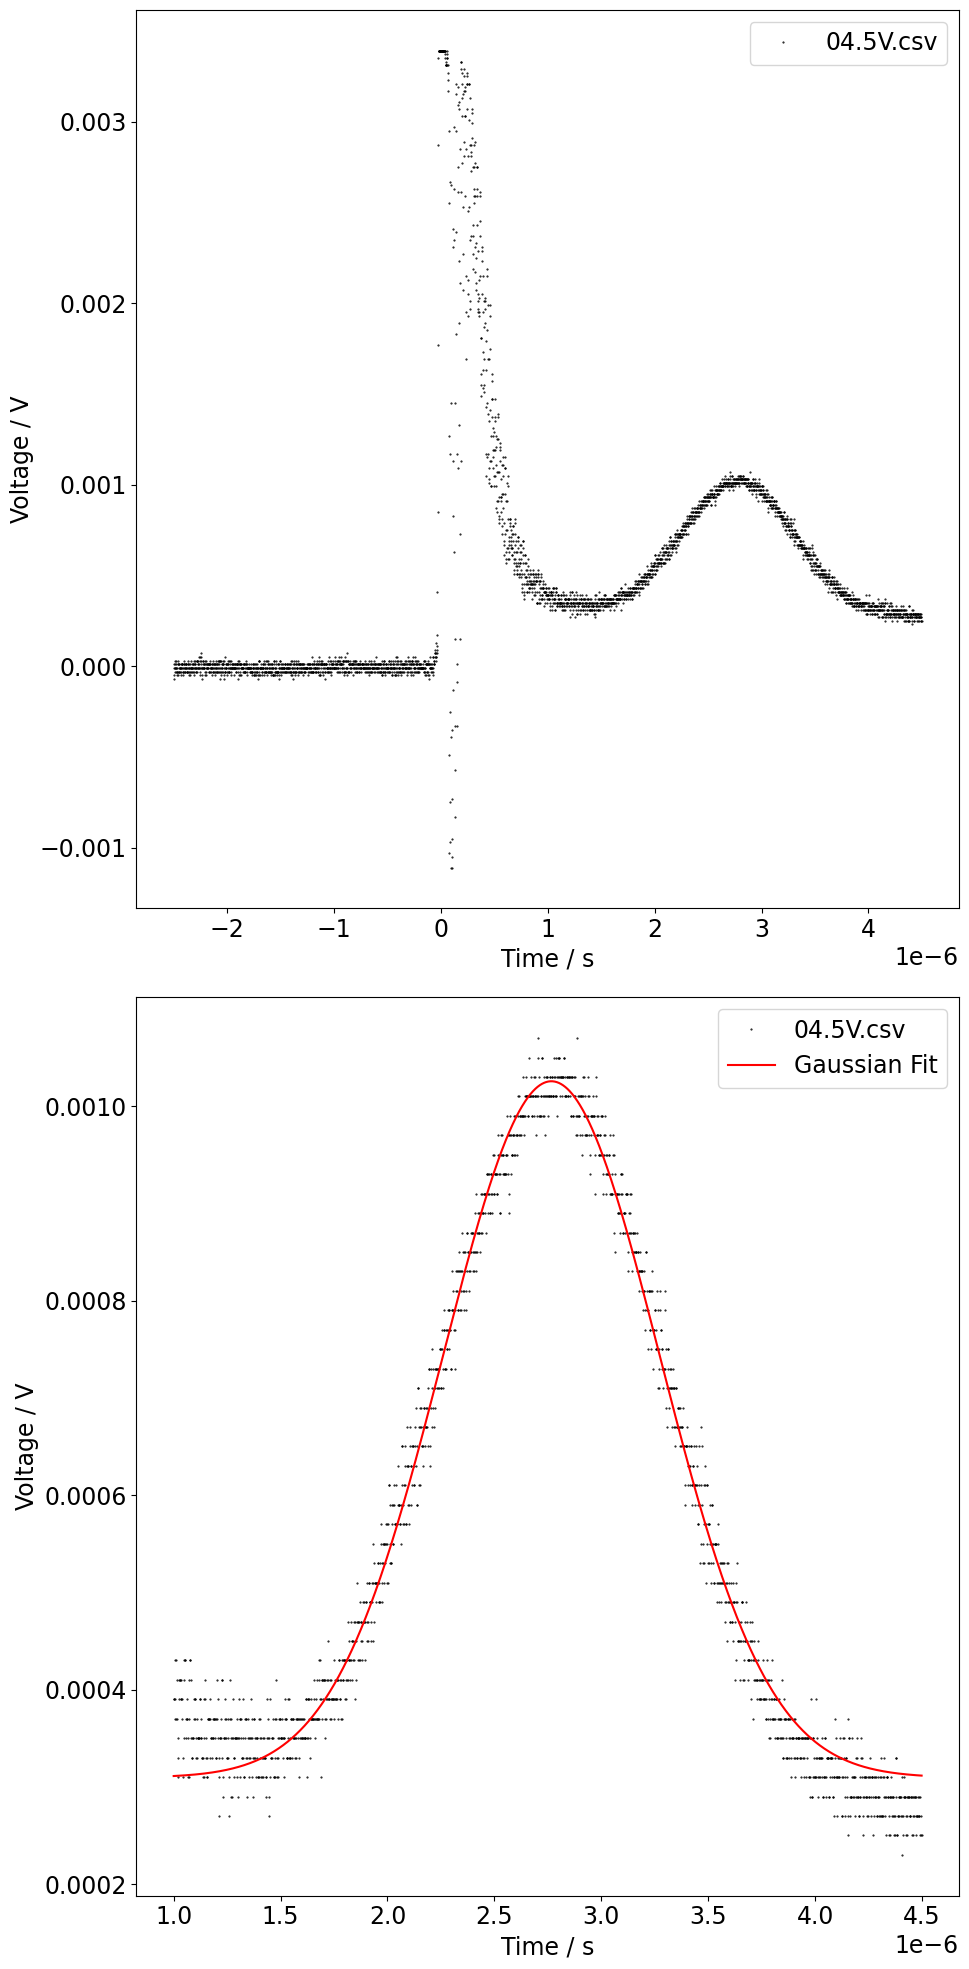

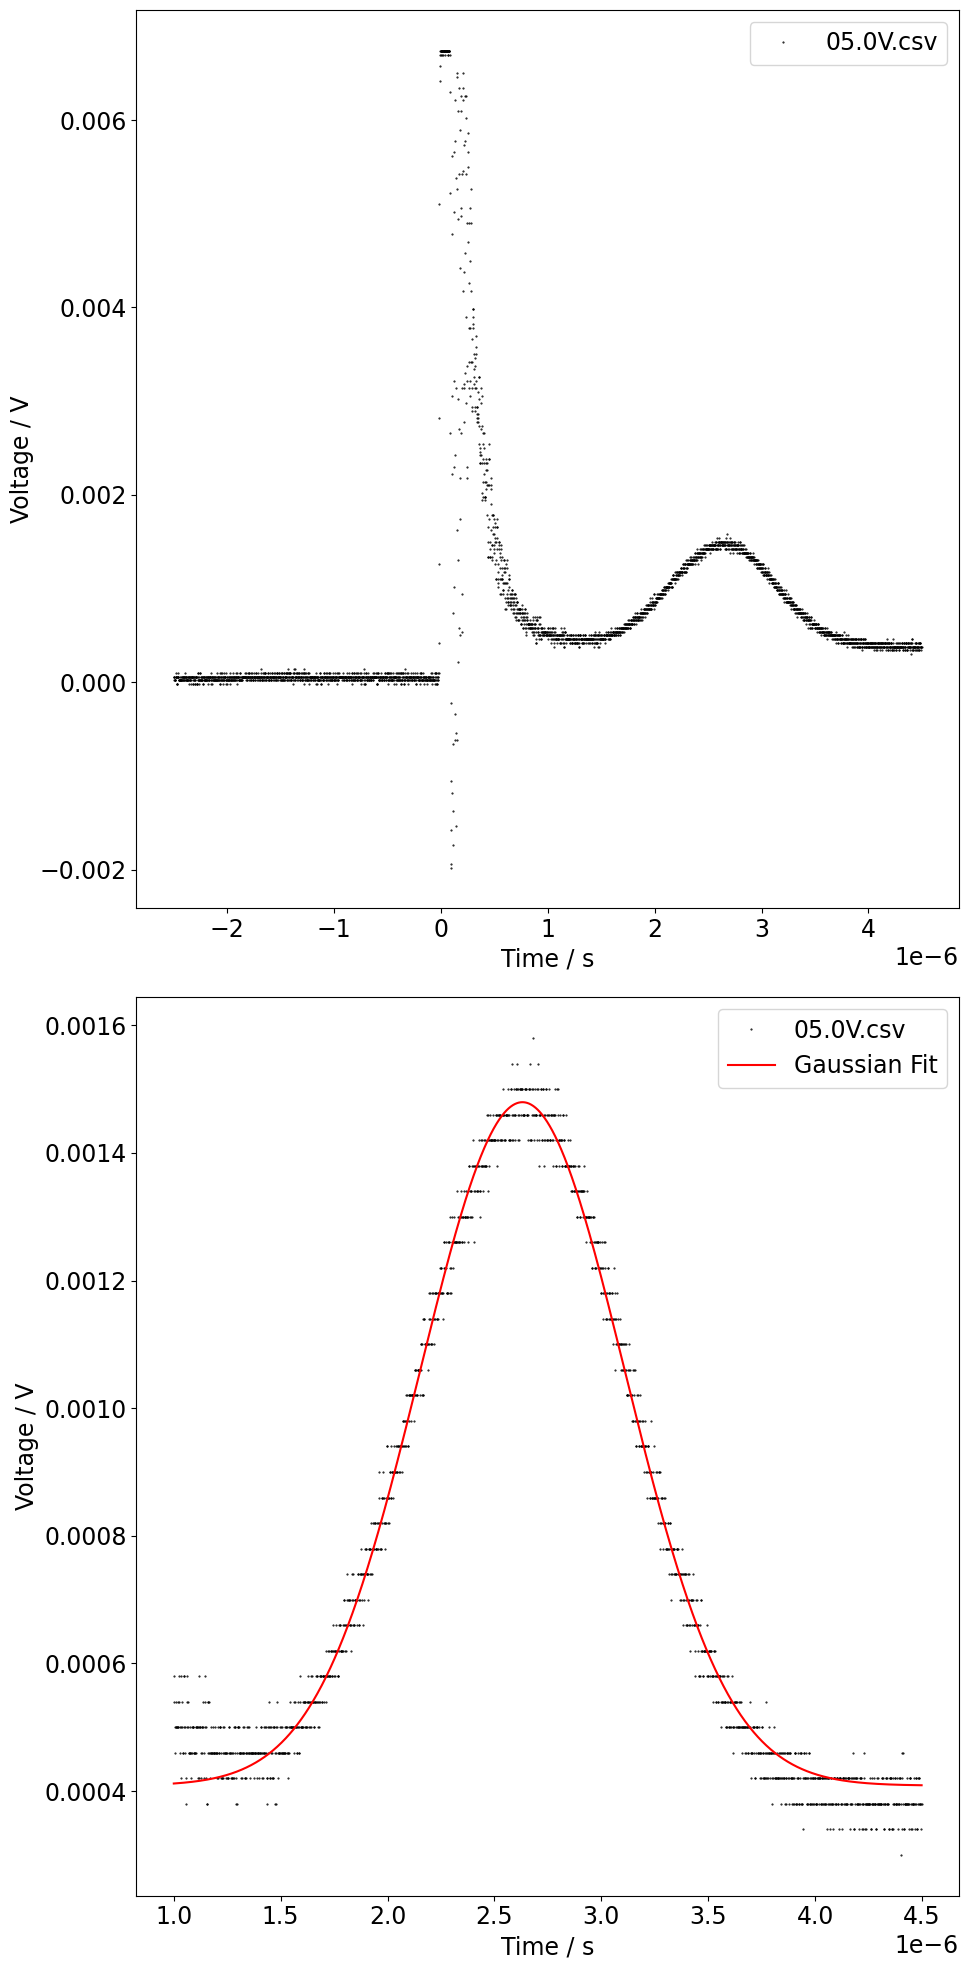

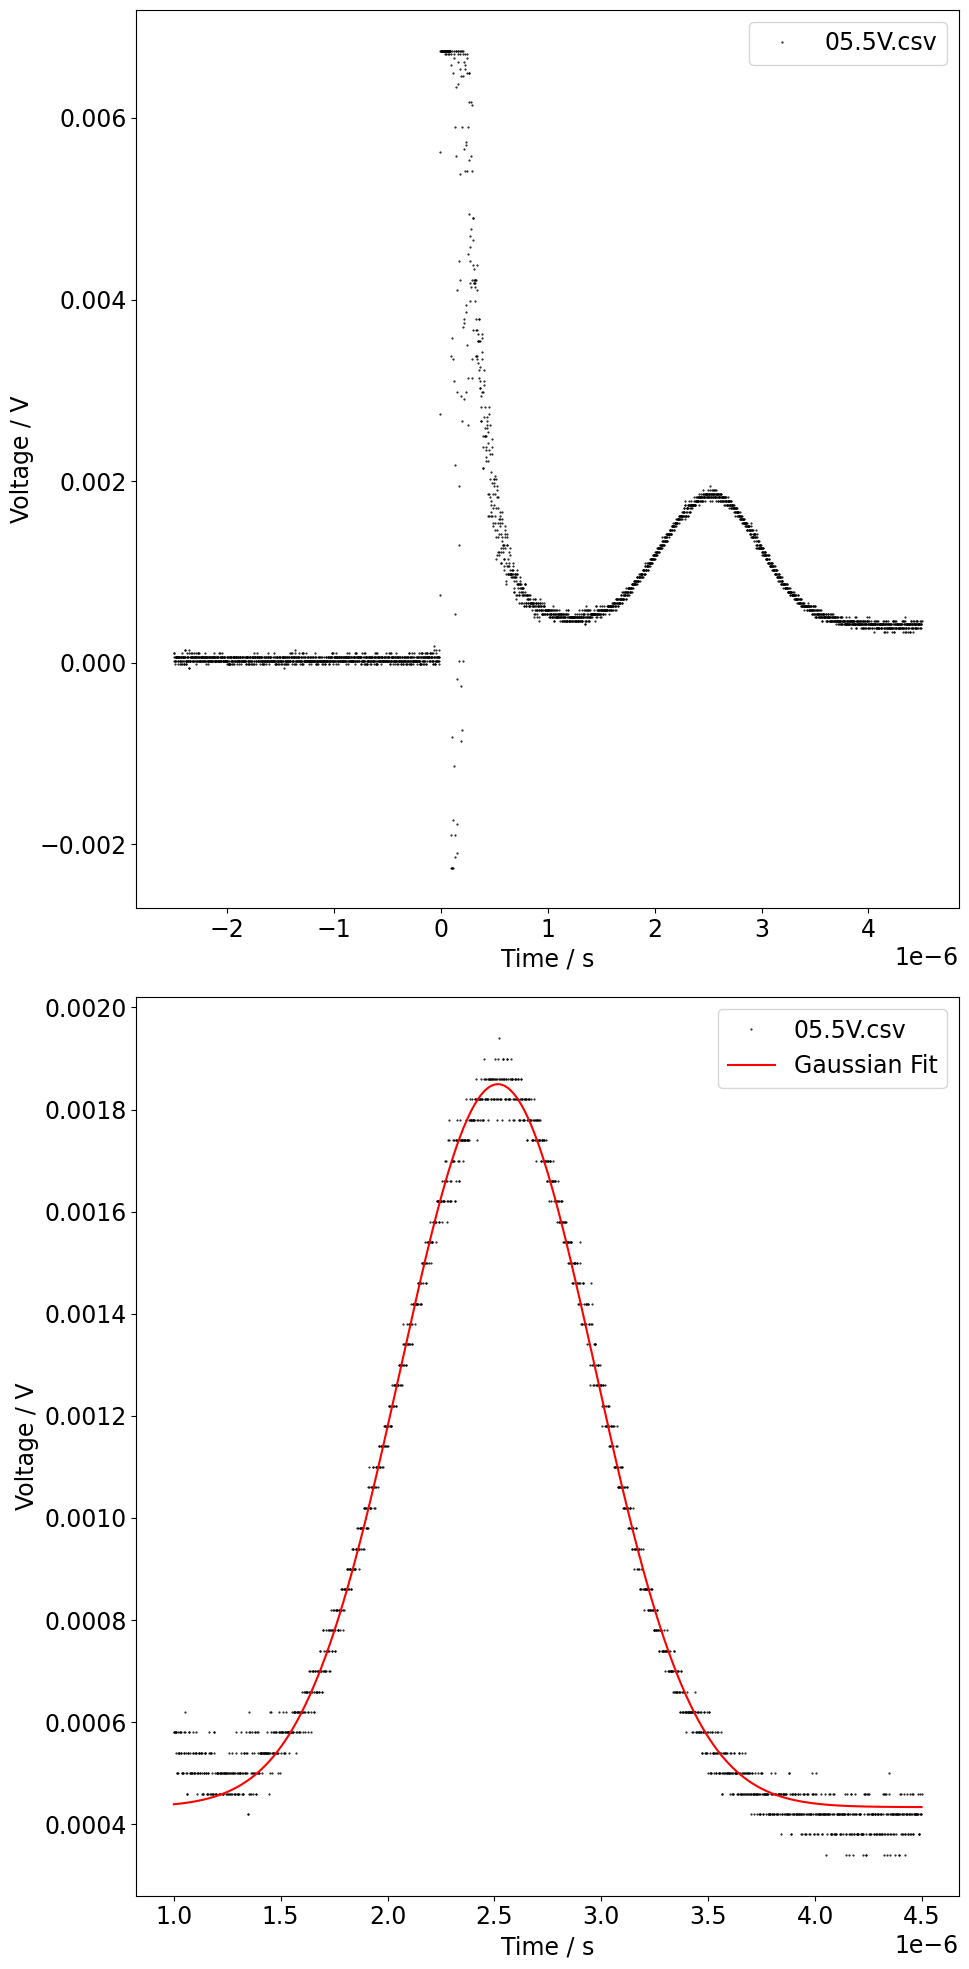

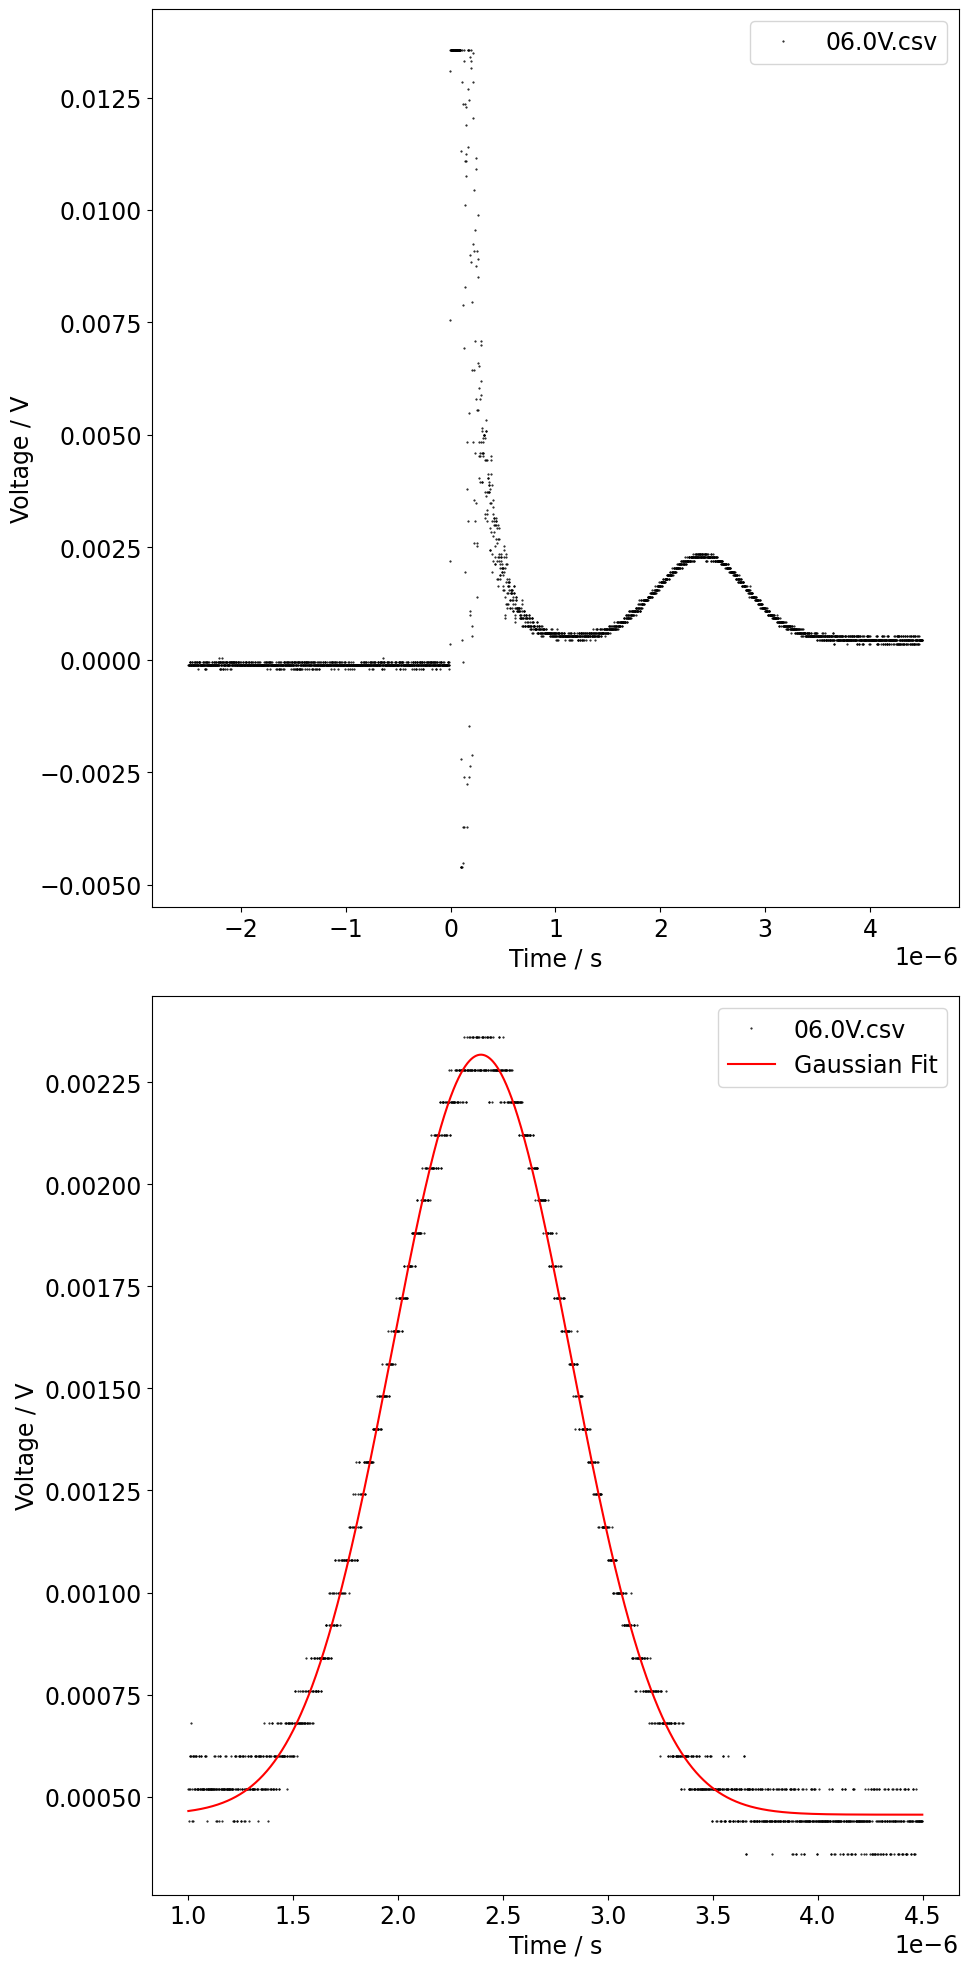

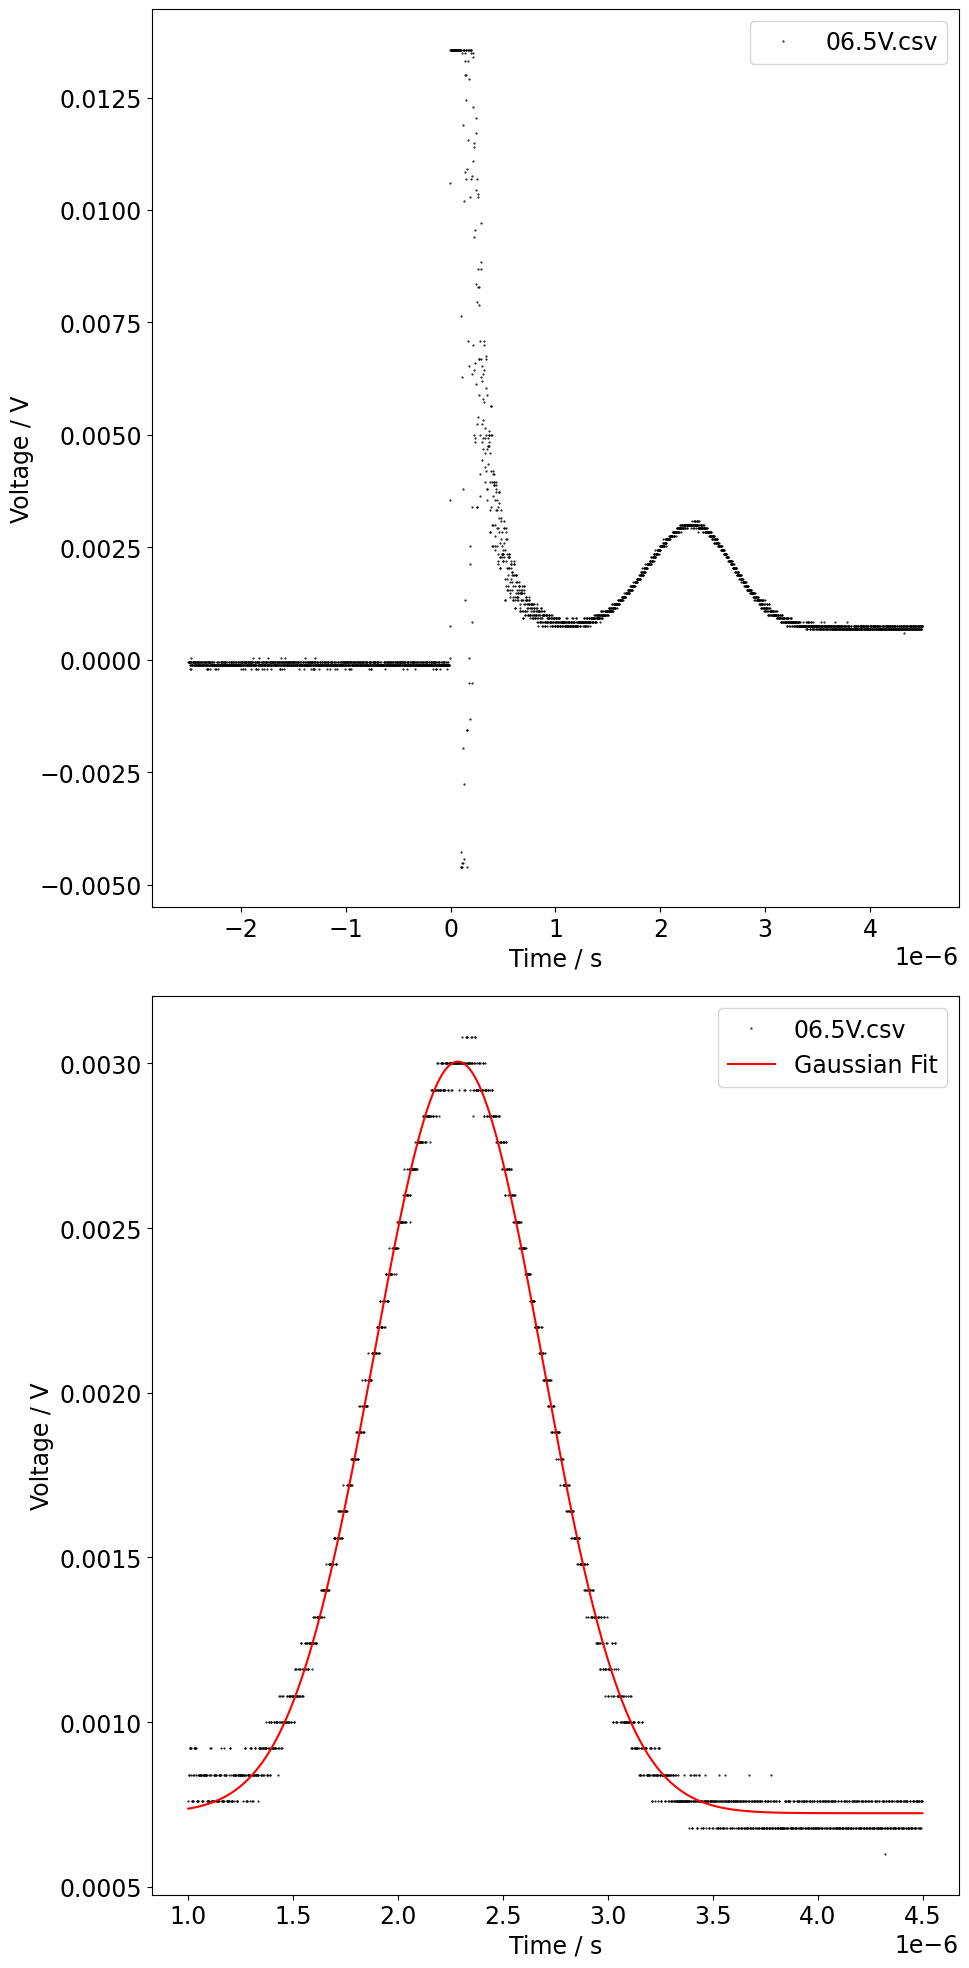

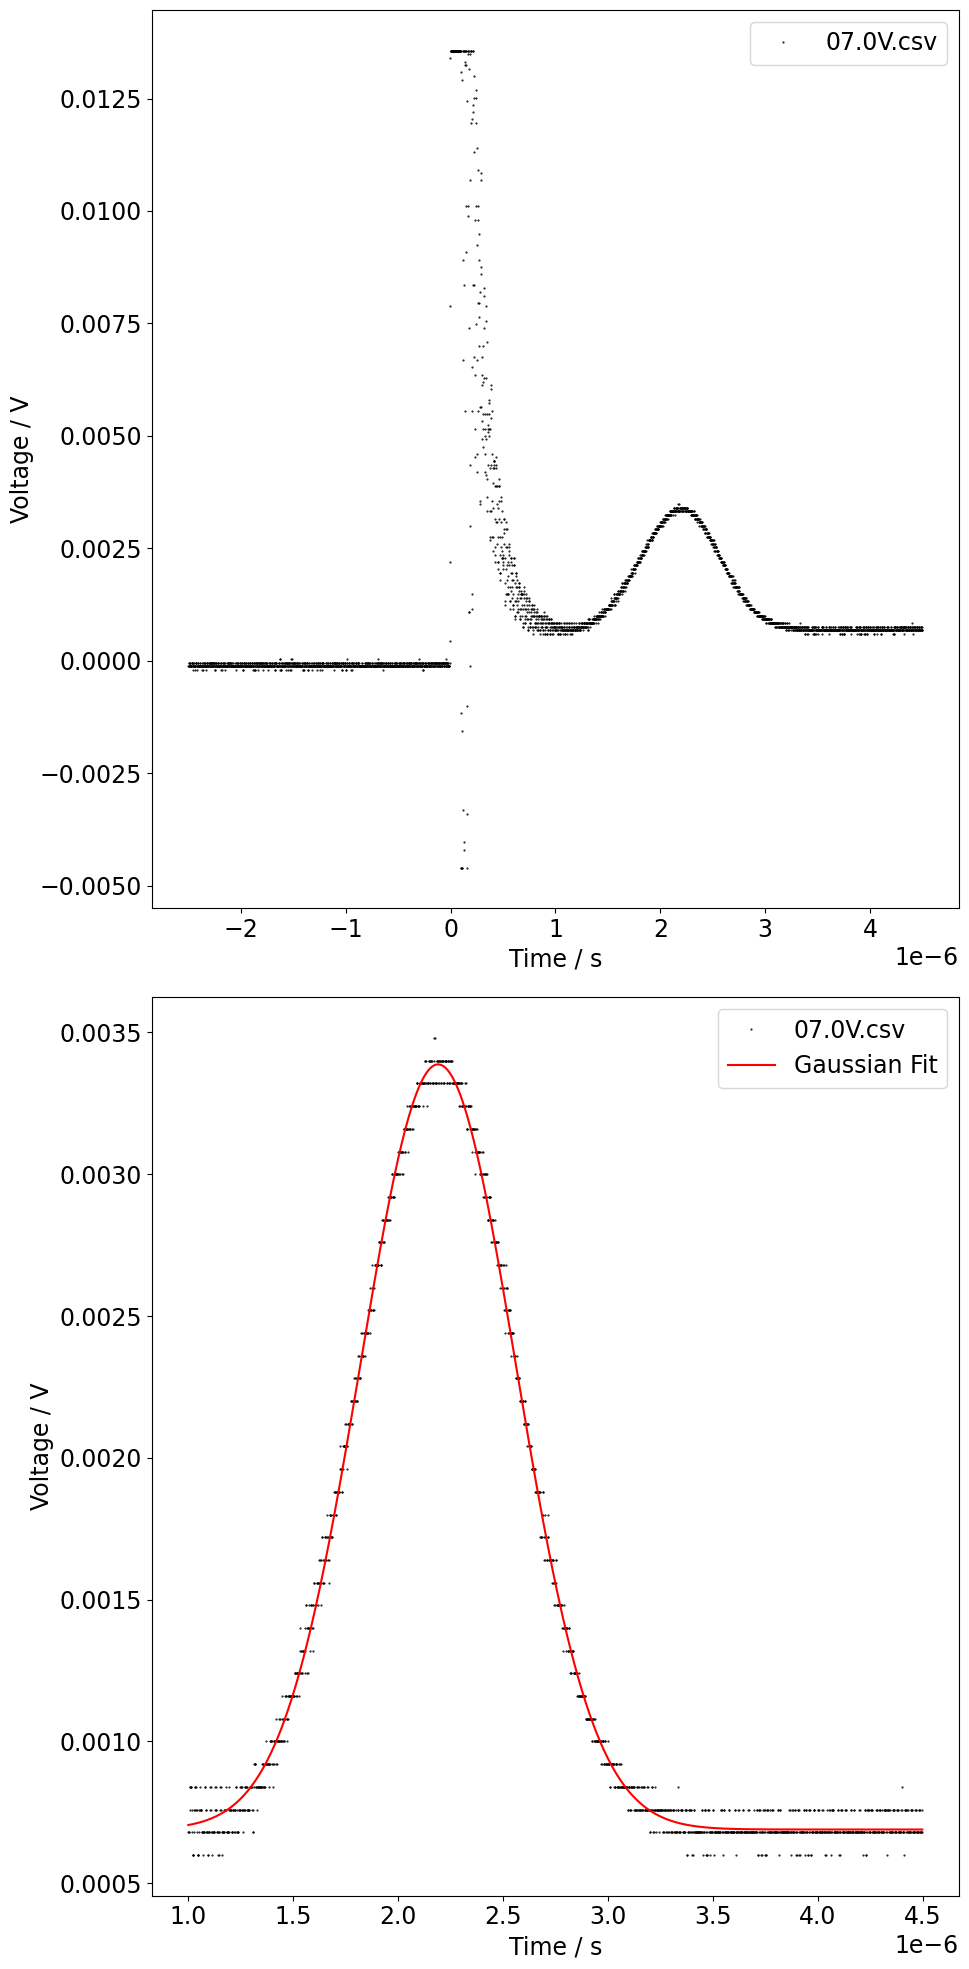

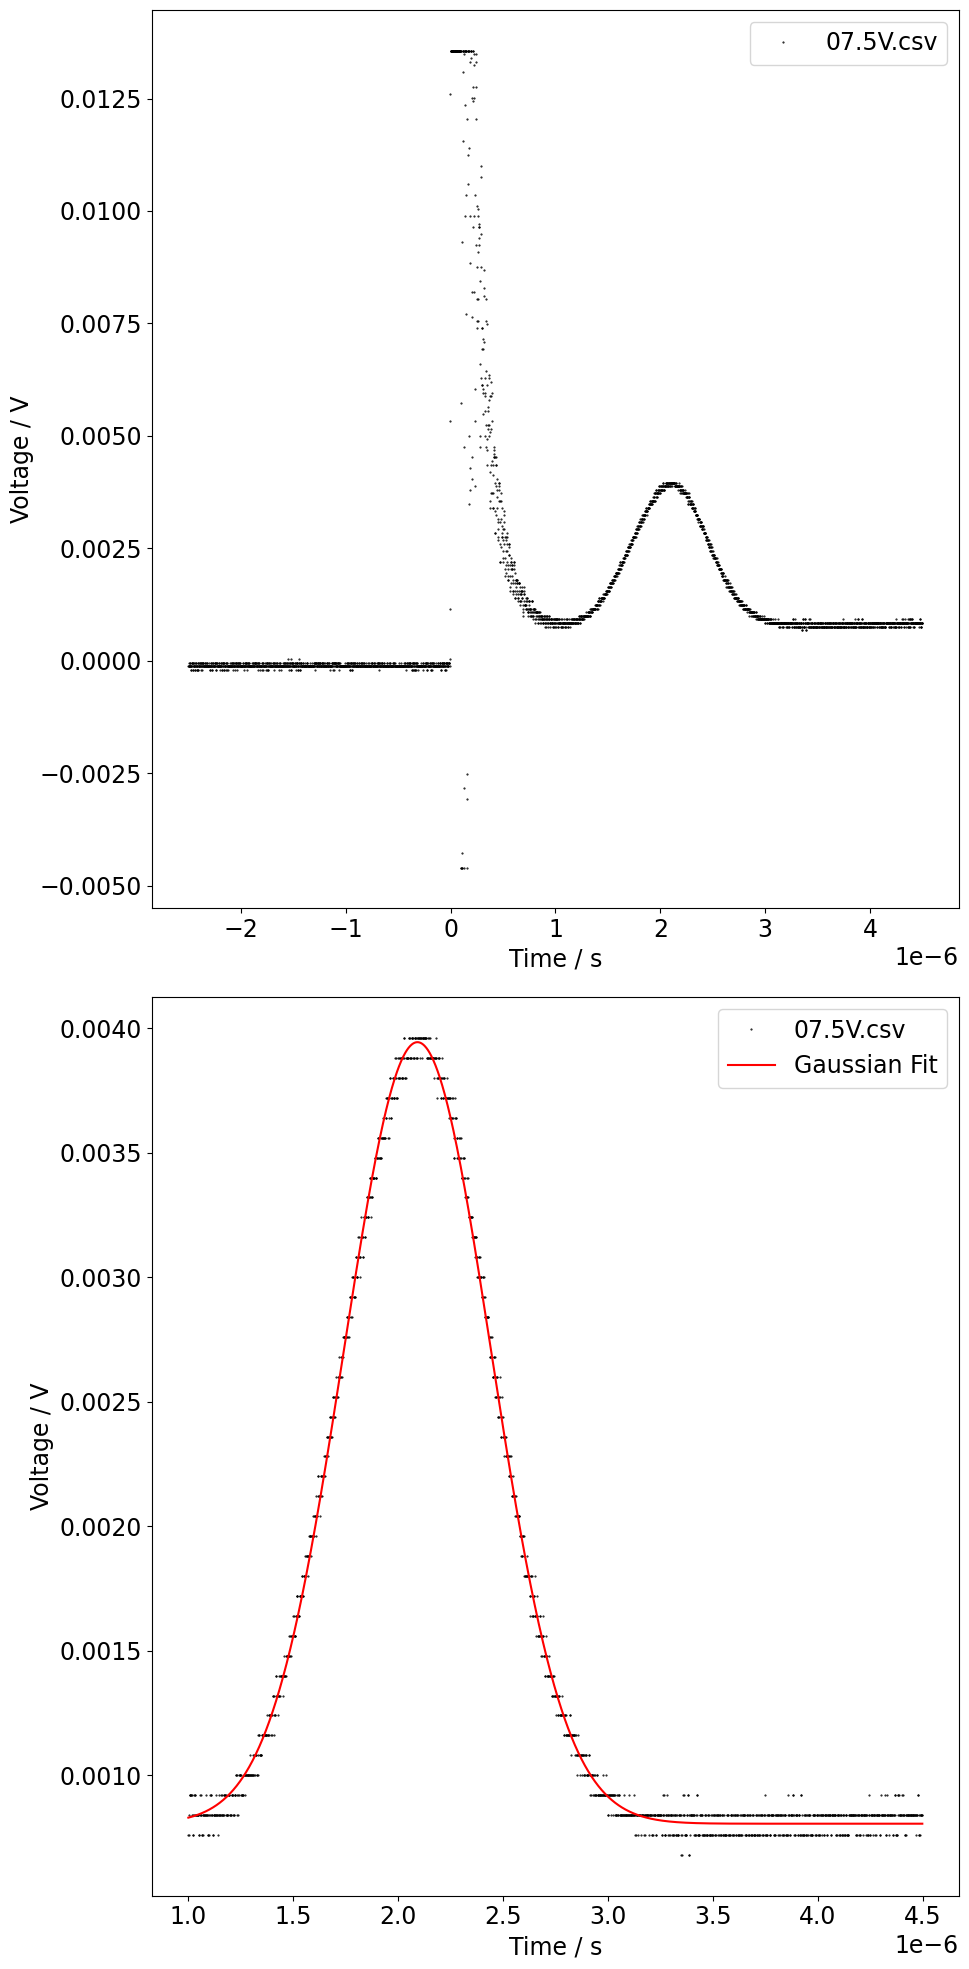

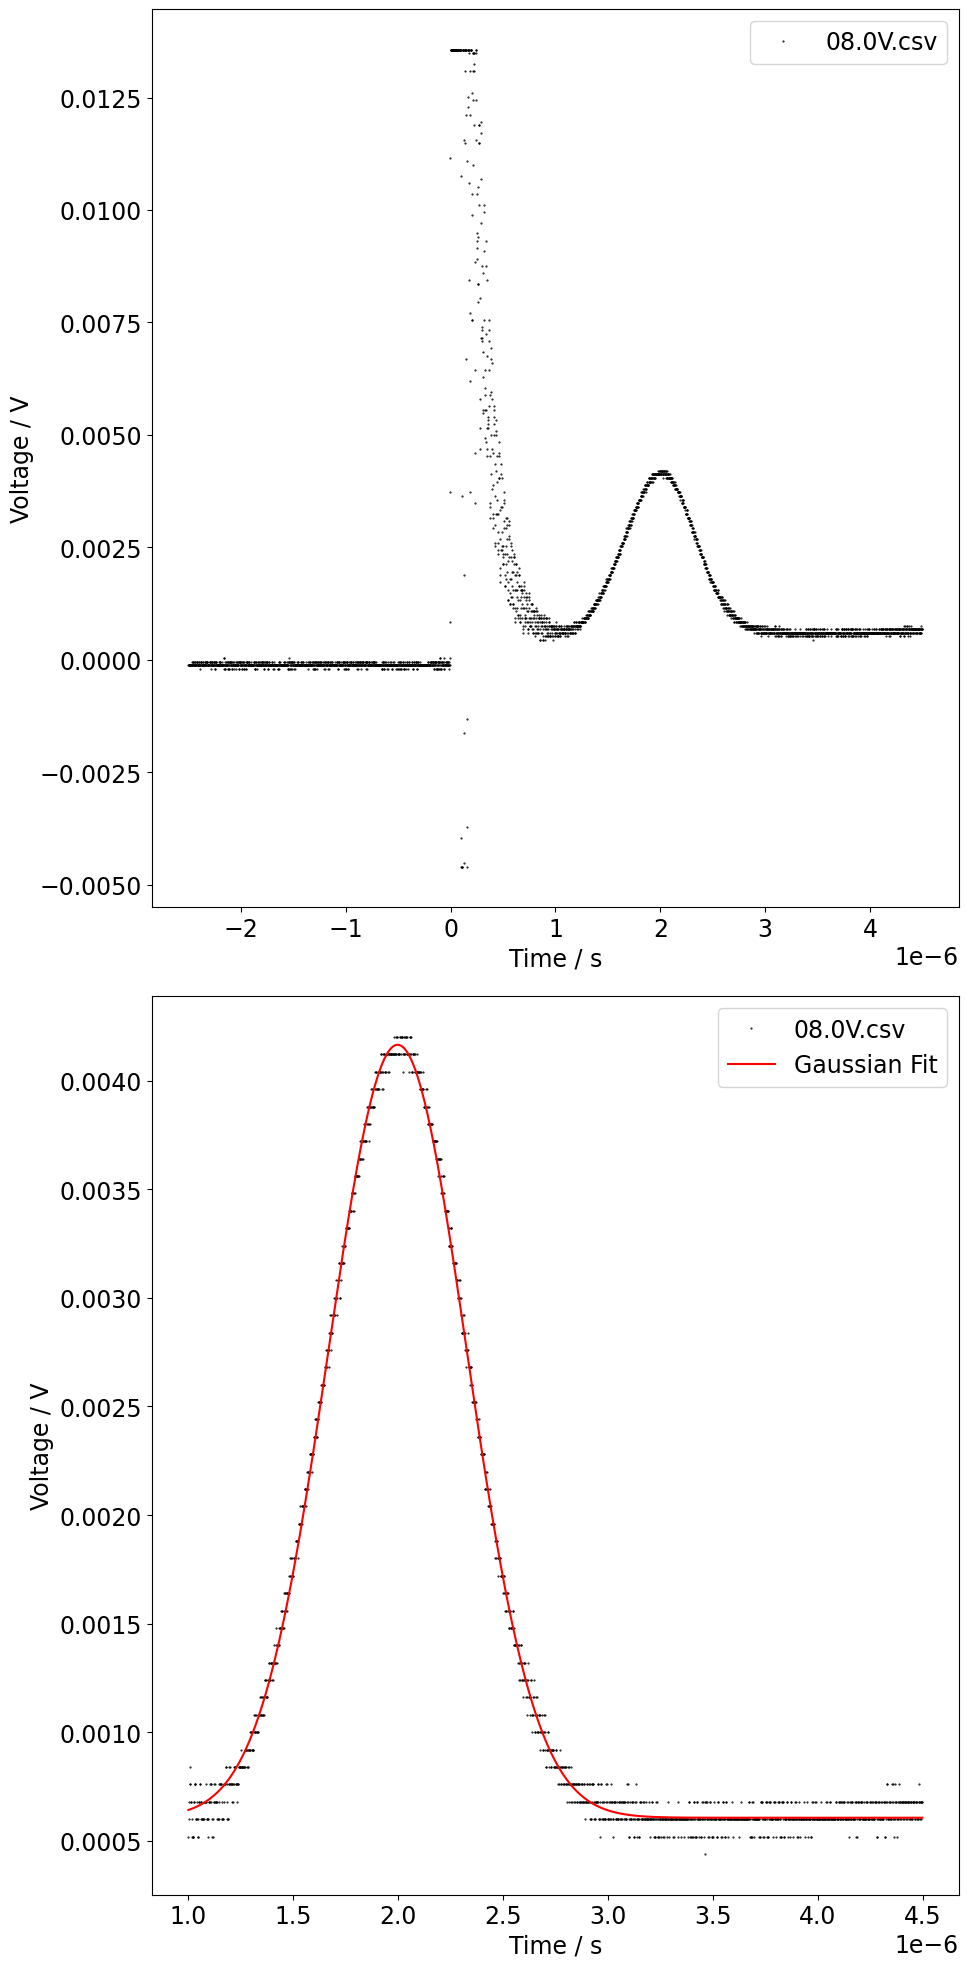

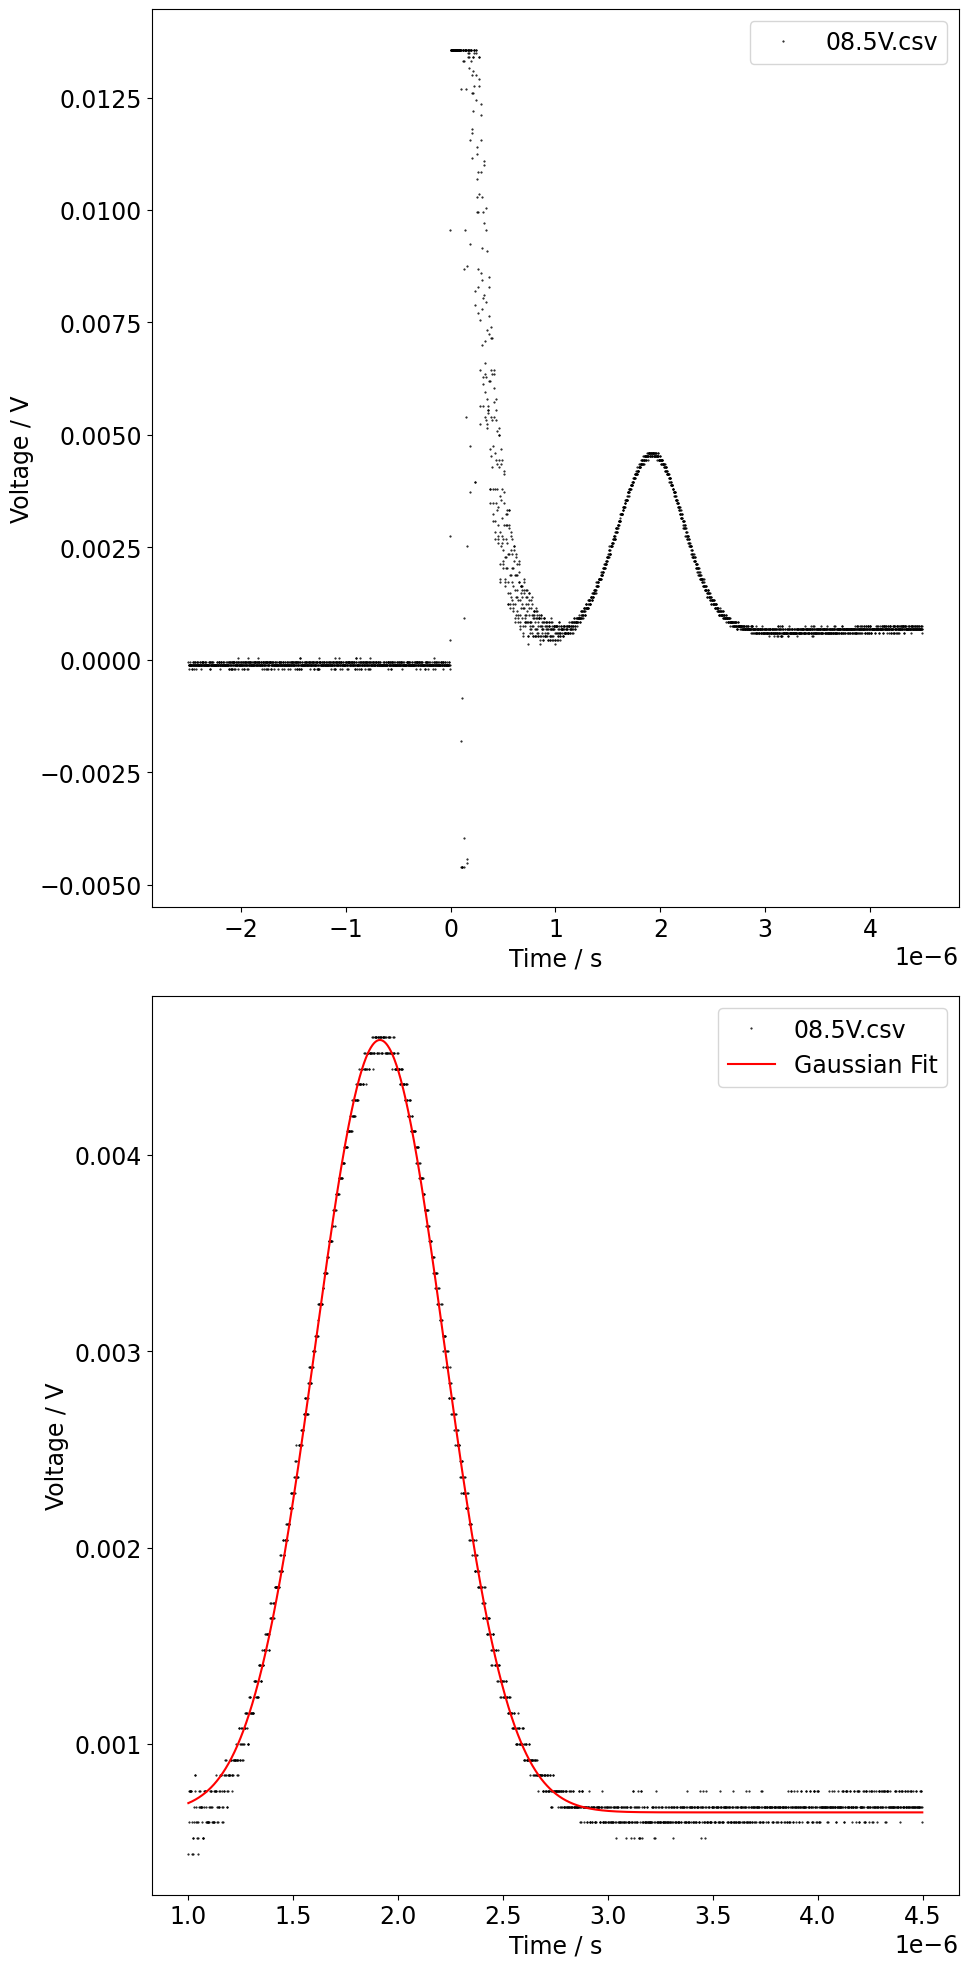

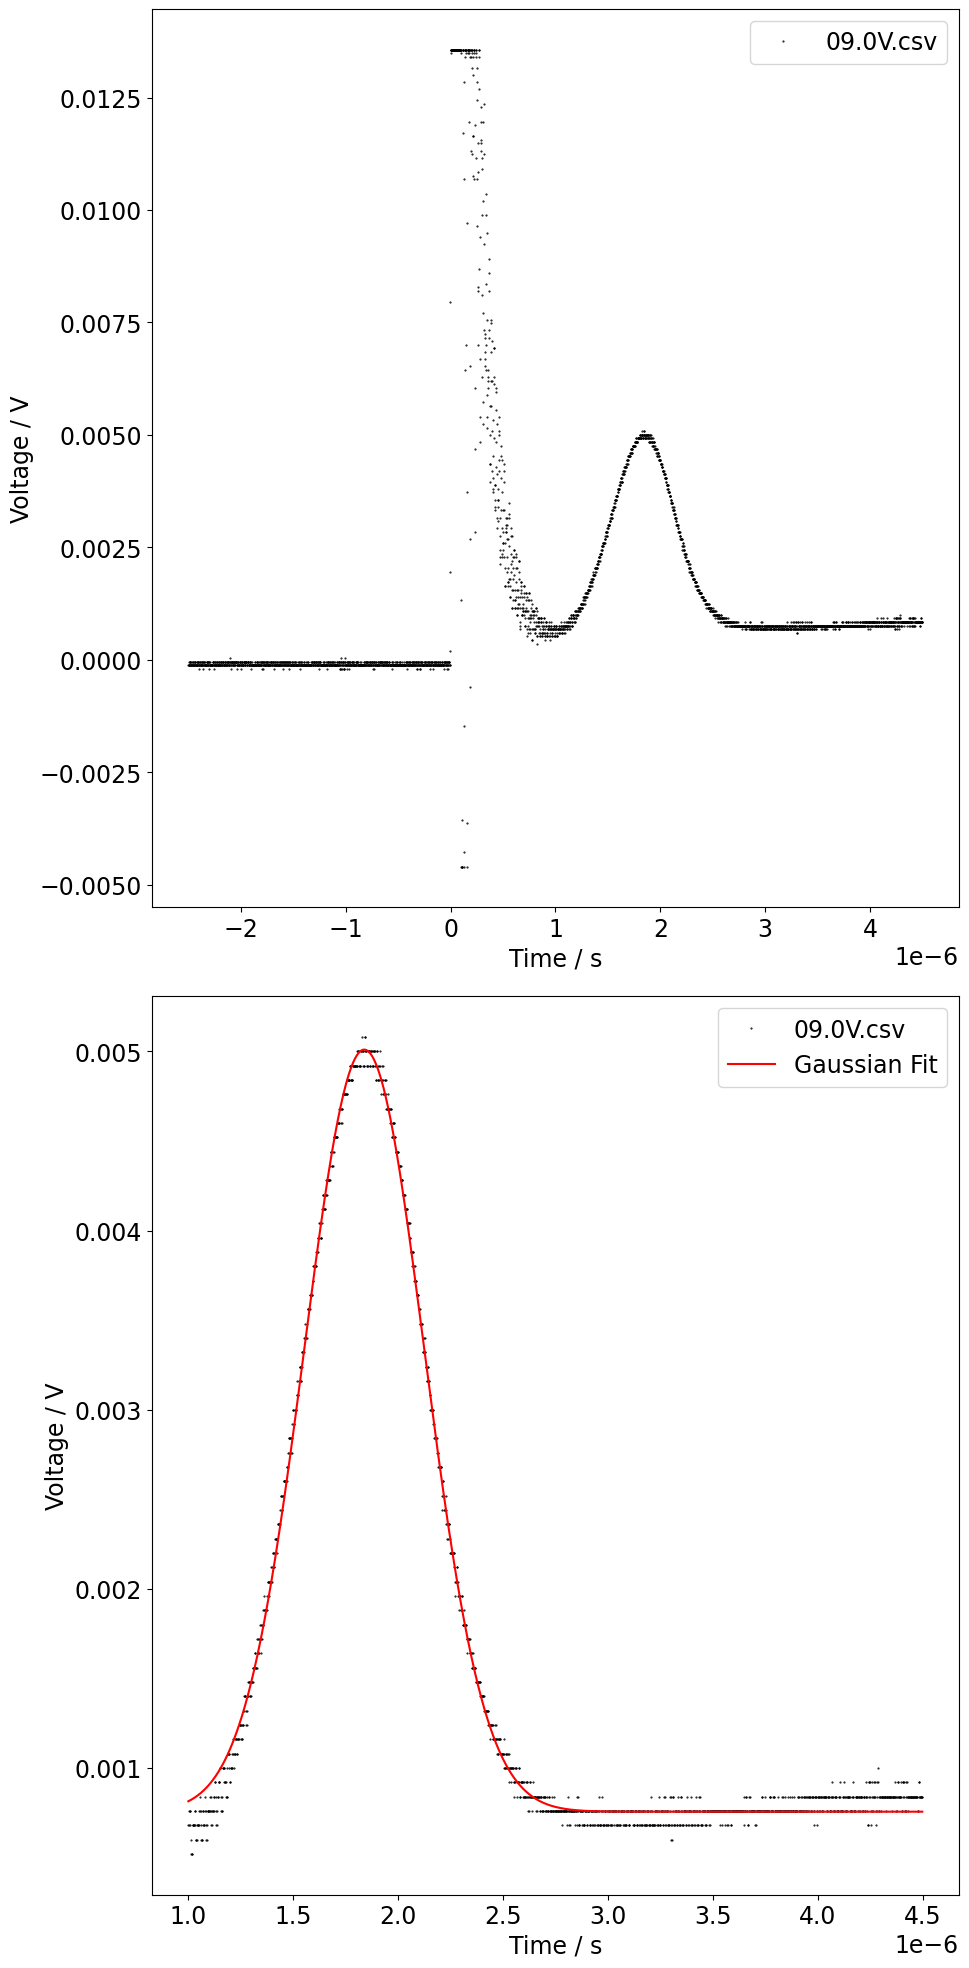

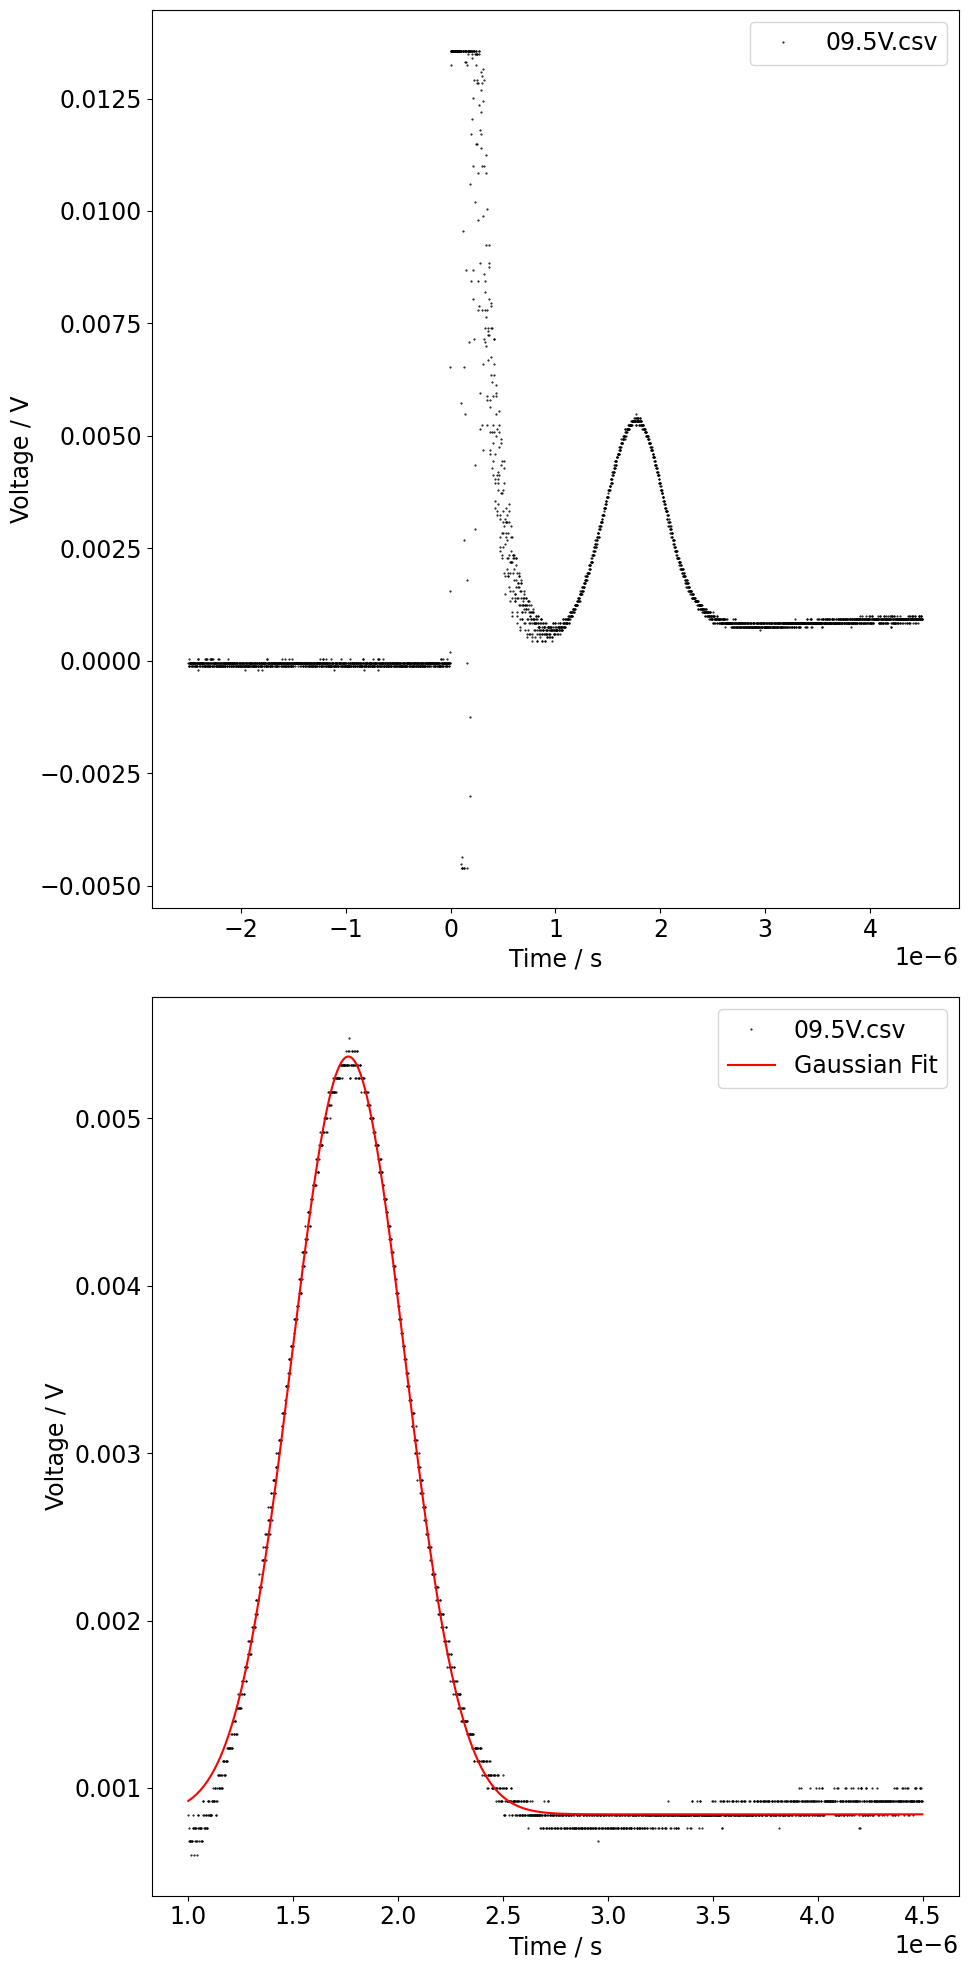

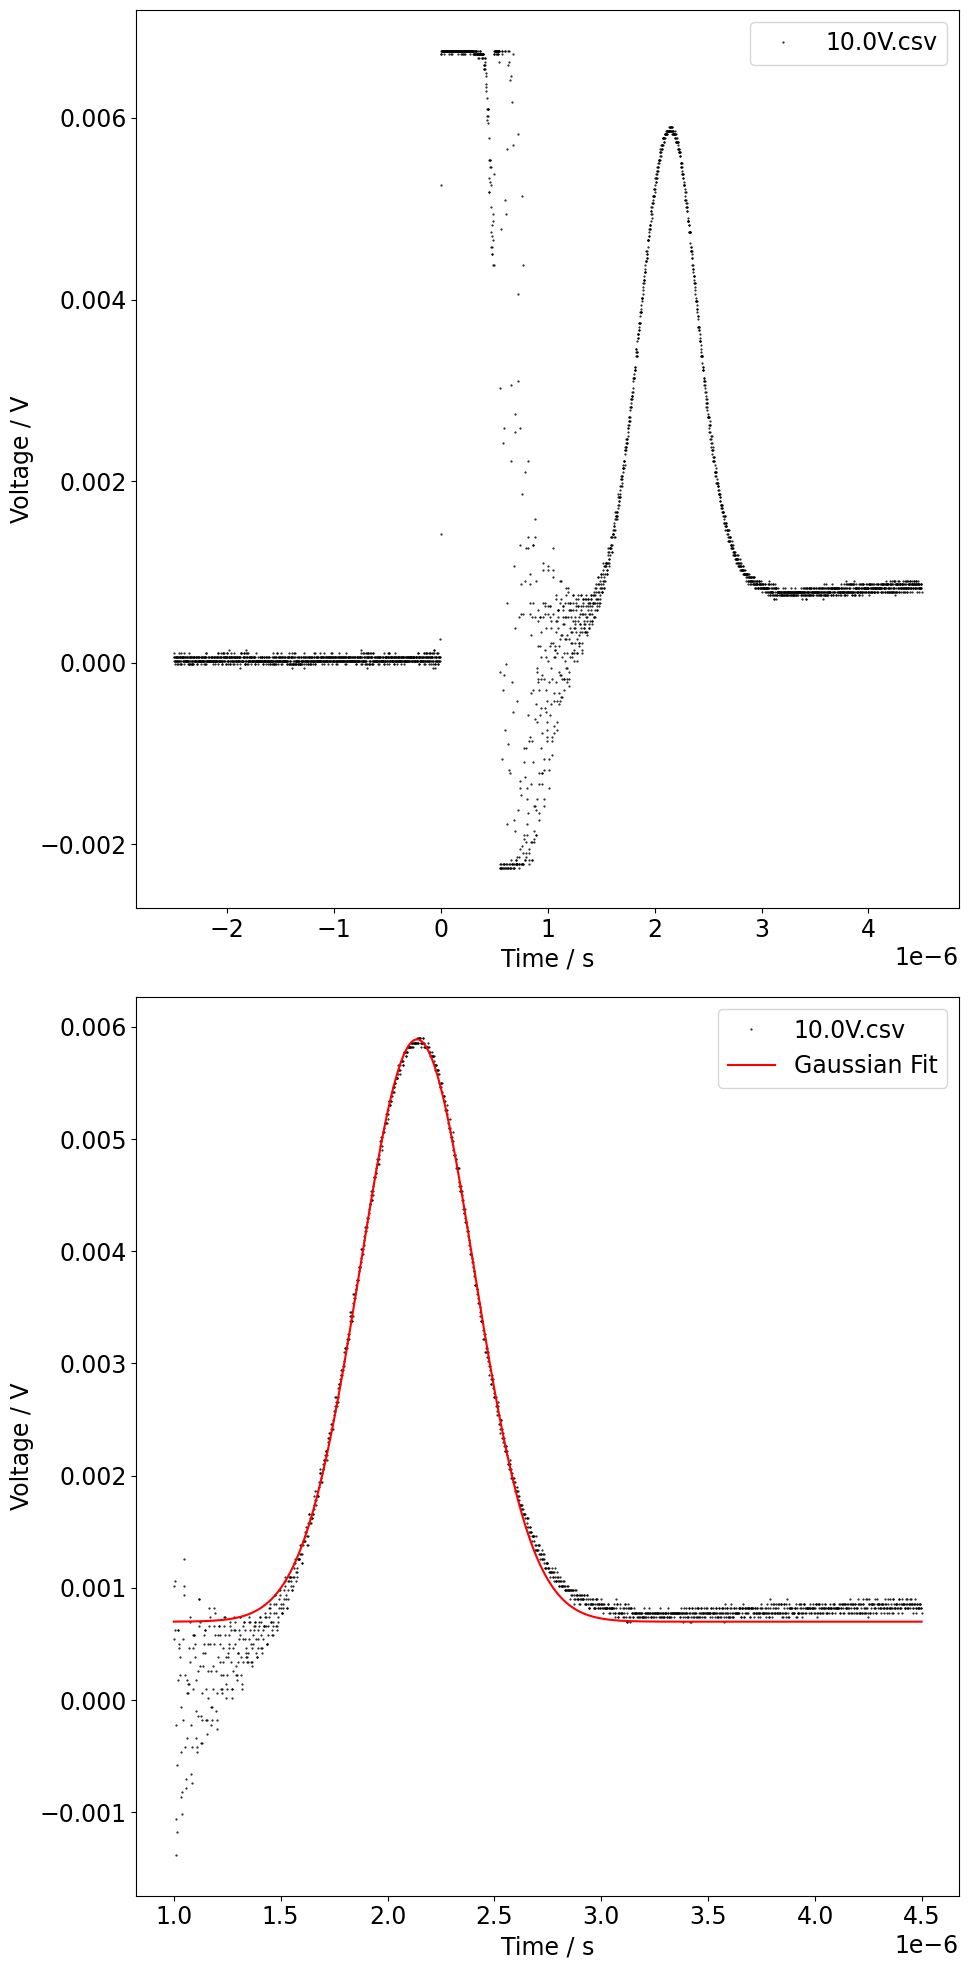

In [43]:
for filename, df in c3_data.items():
    # find peak time, peak voltage, and pulse duration
    df_curve = df[df["Source"] >= 1e-6].reset_index(drop=True)                      # only look at curve after 1.5us
    max_index = df_curve["CH2"].idxmax()                                            # index of ampltiude of curve
    popt, pcov = curve_fit(gaussian, df_curve["Source"], df_curve["CH2"], maxfev=50000, p0=[1, np.mean(df_curve["Source"]), np.std(df_curve["Source"]), 0])

    max_time = np.float64(df_curve["Source"][max_index])                            # time of amplitude of curve
    peak_voltage = np.float64(df_curve["CH2"][max_index])                           # amplitude of curve
    pulse_duration = 2 * np.sqrt(2 * np.log(2)) * popt[2]                           # pulse duration

    peak_times = np.append(peak_times, max_time)
    peak_voltages = np.append(peak_voltages, peak_voltage)
    pulse_durations = np.append(pulse_durations, pulse_duration)

    fig = plt.figure(figsize=(10, 20))
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)

    plot_data(fig, ax1, dict(zip(df["Source"], df["CH2"])), filename, "Time / s", "Voltage / V",  marker=".",  markersize=1)                                     
    plot_data(fig, ax2, dict(zip(df_curve["Source"], df_curve["CH2"])), filename, None, None, marker=".", markersize=1)                           
    plot_data(fig, ax2, dict(zip(df_curve["Source"], gaussian(df_curve["Source"], *popt))), "Gaussian Fit", "Time / s", "Voltage / V", linestyle="-", marker=None, color="red")


## Finding Drift Velocity, Mobility ($\mu$), and the Mean Free Scattering Time ($\tau_{F}$)

In [49]:
peak_time_vs_field_voltage = dict(zip(c3_voltages[4:-1]**-1, peak_times[4:-1]))
pulse_duration_vs_peak_time = dict(zip(peak_times[:-5]**1.5, pulse_durations[:-5]))

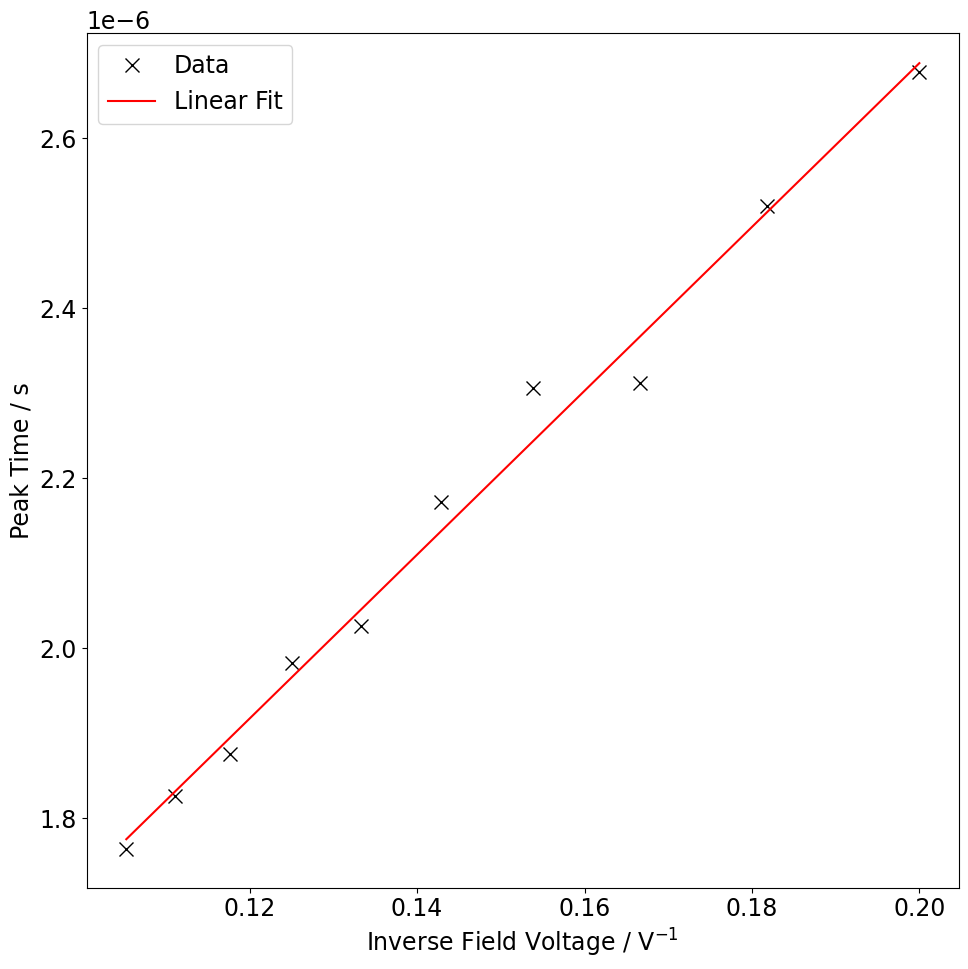

In [45]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 1, 1)

popt, pcov = curve_fit(linear, list(peak_time_vs_field_voltage.keys()), list(peak_time_vs_field_voltage.values()), maxfev=50000)

plot_data(fig, ax1, peak_time_vs_field_voltage, "Data", None, None)
plot_data(fig, ax1, dict(zip(np.array(list(peak_time_vs_field_voltage.keys())), linear(np.array(list(peak_time_vs_field_voltage.keys())), popt[0], popt[1]))), "Linear Fit", "Inverse Field Voltage / V$^{-1}$", "Peak Time / s", color="red", linestyle="-", marker=None, xlims=None, ylims=None, markersize=None)


In [46]:
mobility = (d_3 * BARLENGTH) / popt[0]
mobility_uncertainty = mobility * (pcov[0][0]**0.5) / popt[0]
print(f"Mobility = {mobility * 1e4:.3g} +/- {mobility_uncertainty*1e4:.2g} cm^2 V^-1 s^-1")

thermal_velocity = np.sqrt((3 * k_b * temperature)/hole_effective_mass)
print(f"Thermal Velocity = {thermal_velocity:.3g} m s^-1")

mean_free_scattering_time = (mobility * 1e3 * hole_effective_mass)/charge
mean_free_scattering_time_uncertainty = mean_free_scattering_time * (mobility_uncertainty/mobility)
print(f"Mean Free Scattering Time = {mean_free_scattering_time * 1e12:.3g} +/- {mean_free_scattering_time_uncertainty*1e12:.2g} ps")


Mobility = 370 +/- 14 cm^2 V^-1 s^-1
Thermal Velocity = 1.82e+05 m s^-1
Mean Free Scattering Time = 86.3 +/- 3.3 ps


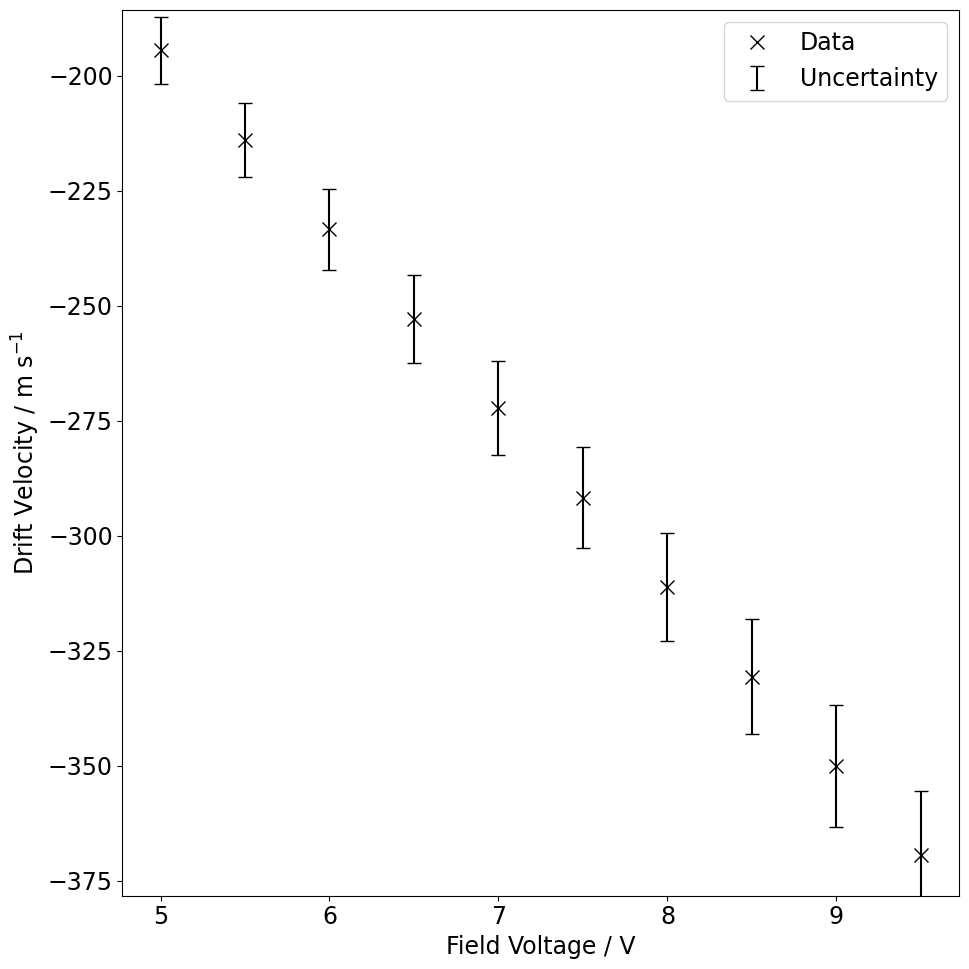

In [47]:
drift_velocity = - (c3_voltages[4:-1]*mobility) / BARLENGTH
drift_velocity_uncertainty = np.abs(drift_velocity * (mobility_uncertainty/mobility))

drift_velocity_vs_field_voltage = dict(zip(c3_voltages[4:-1], drift_velocity))

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 1, 1)



plot_data(fig, ax1, drift_velocity_vs_field_voltage, "Data", "Field Voltage / V", "Drift Velocity / m s$^{-1}$", color="black", linestyle="None", marker="x", markersize=10, xlims=None, ylims=None)

ax1.errorbar(
    c3_voltages[4:-1],
    drift_velocity,
    yerr=drift_velocity_uncertainty,
    color="black",
    ls="None",
    markersize=10,
    capsize=5,
    label="Uncertainty",
)


ax1.set_xlabel("Field Voltage / V")
ax1.set_ylabel("Drift Velocity / m s$^{-1}$")
ax1.legend()

plt.show()

## Carrier Diffusion

Diffusion Coefficient = 11.2 +/- 0.57 cm^2 s^-1


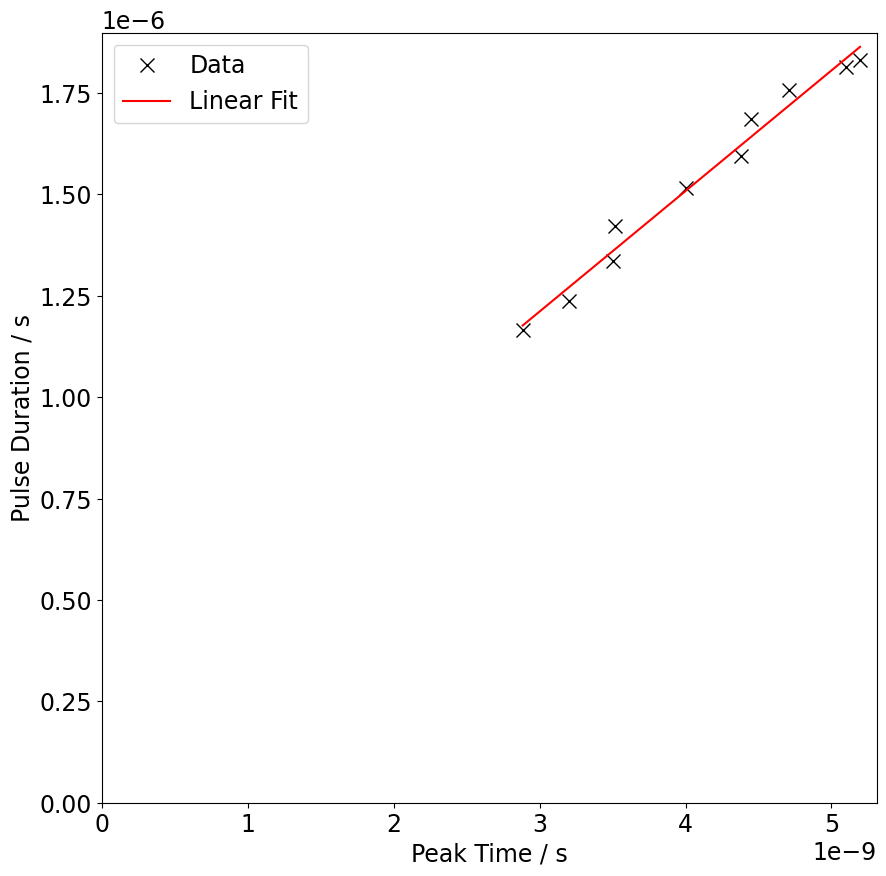

In [50]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(
    np.array(list(pulse_duration_vs_peak_time.keys())),
    np.array(list(pulse_duration_vs_peak_time.values())),
    color="black",
    ls="None",
    label="Data",
    marker="x",
    markersize=10,
)





popt, pcov = curve_fit(linear, np.array(list(pulse_duration_vs_peak_time.keys())), np.array(list(pulse_duration_vs_peak_time.values())), maxfev=50000)
ax1.plot(
    np.array(list(pulse_duration_vs_peak_time.keys())),
    linear(np.array(list(pulse_duration_vs_peak_time.keys())), *popt),
    label="Linear Fit",
    color="red",
    ls="-",
)




ax1.set_xlabel("Peak Time / s")
ax1.set_ylabel("Pulse Duration / s")
ax1.legend()
ax1.set_xlim(xmin=0)
ax1.set_ylim(ymin=0)

diffusion_coefficient = (popt[0] * d_3) ** 2 / (16*np.log(2))
diffusion_coefficient_uncertainty = diffusion_coefficient * (pcov[0][0]**0.5) / popt[0]
print(f"Diffusion Coefficient = {diffusion_coefficient * 1e4:.3g} +/- {diffusion_coefficient_uncertainty * 1e4:.2g} cm^2 s^-1")


## Finding Carrier Lifetime

In [ ]:
drift_time_against_field_voltage = dict(zip(c3_voltages * peak_voltages * pulse_durations, ))